In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For regression modeling and diagnostics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

# For regularization techniques
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# For normality test
from scipy.stats import shapiro

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

In [4]:
# 1. Load the Dataset
financial_data = pd.read_csv("Downloads/2018_Financial_Data.csv", na_values = ["NA", "na", "?"])
financial_data.columns

Index(['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit', 'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Receivables growth', 'Inventory Growth', 'Asset Growth',
       'Book Value per Share Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Sector', '2019 PRICE VAR [%]', 'Class'],
      dtype='object', length=225)

In [7]:
financial_data.columns = financial_data.columns.str.lower()

# Choosing a subset of explanatory variables for dependent variable pe ratio
column_mapping = {
    "revenue growth": "revenue growth",
    "dividend per share": "dividend per share",
    "profit margin": "profit margin",
    "return on equity": "roe",
    "free cash flow": "free cash flow",
    "asset growth": "asset growth",
    "debt growth": "debt growth",
    "r&d expenses": "r&d expenses",
    "net income per share": "net income per share",
    "pe ratio": "pe ratio"
}

financial_data = financial_data[list(column_mapping.values())]

In [9]:
# Cleaning data to keep records that are not missing data
financial_data = financial_data.dropna()
financial_data.info()
financial_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 3998 entries, 0 to 4391
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   revenue growth        3998 non-null   float64
 1   dividend per share    3998 non-null   float64
 2   profit margin         3998 non-null   float64
 3   roe                   3998 non-null   float64
 4   free cash flow        3998 non-null   float64
 5   asset growth          3998 non-null   float64
 6   debt growth           3998 non-null   float64
 7   r&d expenses          3998 non-null   float64
 8   net income per share  3998 non-null   float64
 9   pe ratio              3998 non-null   float64
dtypes: float64(10)
memory usage: 343.6 KB


revenue growth          0
dividend per share      0
profit margin           0
roe                     0
free cash flow          0
asset growth            0
debt growth             0
r&d expenses            0
net income per share    0
pe ratio                0
dtype: int64

In [11]:
from scipy.stats.mstats import winsorize

#Finds the values for 1st percentile and 99th percentile
rg_lower, rg_upper = np.percentile(financial_data["revenue growth"].dropna(), [1, 99])
dps_lower, dps_upper = np.percentile(financial_data["dividend per share"].dropna(), [1, 99])
pm_lower, pm_upper = np.percentile(financial_data["profit margin"].dropna(), [1, 99])
roe_lower, roe_upper = np.percentile(financial_data["roe"].dropna(), [1, 99])
fcf_lower, fcf_upper = np.percentile(financial_data["free cash flow"].dropna(), [1, 99])
ag_lower, ag_upper = np.percentile(financial_data["asset growth"].dropna(), [1, 99])
dg_lower, dg_upper = np.percentile(financial_data["debt growth"].dropna(), [1, 99])
rd_lower, rd_upper = np.percentile(financial_data["r&d expenses"].dropna(), [1, 99])
nips_lower, nips_upper = np.percentile(financial_data["net income per share"].dropna(), [1, 99])
pe_lower, pe_upper = np.percentile(financial_data["pe ratio"].dropna(), [1, 99])

print(f"Revenue Growth Winsorization Limits: {rg_lower} to {rg_upper}")
print(f"Dividend per Share Winsorization Limits: {dps_lower} to {dps_upper}")
print(f"Profit Margin Winsorization Limits: {pm_lower} to {pm_upper}")
print(f"ROE Winsorization Limits: {roe_lower} to {roe_upper}")
print(f"Free Cash Flow Winsorization Limits: {fcf_lower} to {fcf_upper}")
print(f"Asset Growth Winsorization Limits: {ag_lower} to {ag_upper}")
print(f"Debt Growth Winsorization Limits: {dg_lower} to {dg_upper}")
print(f"R&D Expenses Winsorization Limits: {rd_lower} to {rd_upper}")
print(f"Net Income Per Share Winsorization Limits: {nips_lower} to {nips_upper}")
print(f"PE ratio Winsorization Limits: {pe_lower} to {pe_upper}")

Revenue Growth Winsorization Limits: -0.819203 to 4.717499999999949
Dividend per Share Winsorization Limits: 0.0 to 5.300599999999995
Profit Margin Winsorization Limits: -118.47212 to 0.7915099999999956
ROE Winsorization Limits: -6.022384 to 4.0910789999999775
Free Cash Flow Winsorization Limits: -1127347770.0 to 12169453096.234291
Asset Growth Winsorization Limits: -0.5349090000000001 to 2.0788699999999976
Debt Growth Winsorization Limits: -1.0 to 12.56062099999979
R&D Expenses Winsorization Limits: 0.0 to 2266335165.6441708
Net Income Per Share Winsorization Limits: -28.585804000000003 to 1143.35213799995
PE ratio Winsorization Limits: 0.0 to 266.4572919999969


In [13]:
# Apply Winsorization using clip() for exact percentile-based capping
financial_data["Revenue Growth_winsorized"] = financial_data["revenue growth"].clip(lower=-0.8192, upper=4.7175)
financial_data["Dividend per Share_winsorized"] = financial_data["dividend per share"].clip(lower=0.0, upper=5.3)
financial_data["Profit Margin_winsorized"] = financial_data["profit margin"].clip(lower=-118.47, upper=0.7915)
financial_data["ROE_winsorized"] = financial_data["roe"].clip(lower=-6.022, upper=4.0911)
financial_data["Free Cash Flow_winsorized"] = financial_data["free cash flow"].clip(lower=-1127347770.0, upper=12169453096.23)
financial_data["Asset Growth_winsorized"] = financial_data["asset growth"].clip(lower=-0.5349, upper=2.0789)
financial_data["Debt Growth_winsorized"] = financial_data["debt growth"].clip(lower=-1.0, upper=12.56)
financial_data["R&D Expenses_winsorized"] = financial_data["r&d expenses"].clip(lower=0.0, upper=2266335165.64)
financial_data["Net Income Per Share_winsorized"] = financial_data["net income per share"].clip(lower=-28.59, upper=1143.35)
financial_data["PE ratio_winsorized"] = financial_data["pe ratio"].clip(lower=0.0, upper=266.46)

In [15]:
# List of columns to drop
columns_to_drop = [
    'revenue growth', 'dividend per share', 'profit margin', 'roe',
    'free cash flow', 'asset growth', 'debt growth', 'r&d expenses',
    'net income per share', 'pe ratio'
]

# Drop columns
fin_data = financial_data.drop(columns=columns_to_drop)

# Display updated DataFrame
print(fin_data.head())

   Revenue Growth_winsorized  Dividend per Share_winsorized  \
0                     0.1115                          0.917   
1                     0.0320                          0.725   
2                     0.1289                          1.200   
3                     0.4955                          0.000   
4                     0.0285                          0.370   

   Profit Margin_winsorized  ROE_winsorized  Free Cash Flow_winsorized  \
0                     0.124          0.1638               1.198500e+10   
1                     0.105          0.0478               2.119000e+09   
2                     0.297          0.2824               1.216945e+10   
3                     0.465          0.4377               8.521000e+09   
4                    -0.187         -0.7216               7.090000e+08   

   Asset Growth_winsorized  Debt Growth_winsorized  R&D Expenses_winsorized  \
0                   0.3426                  0.7309             0.000000e+00   
1                 

In [17]:
fin_data_log = fin_data.apply(lambda x: np.log(x + 1))  # log(1 + x) transformation

In [39]:
# Reseting index to match and defining variables for regression
X = fin_data_log.drop(columns = ["PE ratio_winsorized"])
y = fin_data_log['PE ratio_winsorized']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [21]:
# 2. Exploratory Data Analysis (EDA)

# Check for missing values
print("\nMissing values in each column:")
print(fin_data_log.isnull().sum())


Missing values in each column:
Revenue Growth_winsorized             0
Dividend per Share_winsorized         0
Profit Margin_winsorized            373
ROE_winsorized                      228
Free Cash Flow_winsorized          1321
Asset Growth_winsorized               0
Debt Growth_winsorized                0
R&D Expenses_winsorized               0
Net Income Per Share_winsorized     646
PE ratio_winsorized                   0
dtype: int64


In [23]:
fin_data_log.dropna()

,Revenue Growth_winsorized,Dividend per Share_winsorized,Profit Margin_winsorized,ROE_winsorized,Free Cash Flow_winsorized,Asset Growth_winsorized,Debt Growth_winsorized,R&D Expenses_winsorized,Net Income Per Share_winsorized,PE ratio_winsorized
0,0.105710,0.650761,0.116894,0.151691,23.206922,0.294608,0.548642,0.000000,1.274944,2.660315
1,0.031499,0.545227,0.099845,0.046693,21.474210,-0.002403,-0.013795,0.000000,0.545865,3.190600
2,0.121244,0.788457,0.260054,0.248733,23.222195,0.037488,-0.017044,21.541430,1.716641,2.422064
3,0.402461,0.000000,0.381855,0.363045,22.865800,0.204980,-0.877310,21.484539,2.585506,1.667688
5,0.043634,0.431782,0.256965,0.100840,23.222195,0.031596,-0.000800,0.000000,1.331785,2.335372
...,...,...,...,...,...,...,...,...,...,...
4376,-0.434945,0.000000,0.525320,0.037585,15.687216,-0.011364,-0.715802,0.000000,0.424810,5.060084
4379,0.122218,0.615186,0.018822,0.083606,16.428151,0.030820,0.000000,0.000000,0.594321,2.626153
4380,0.135929,0.000000,0.001000,0.001099,14.958778,-0.060493,0.097308,15.406581,0.001699,0.000000
4381,0.112614,0.277632,0.266203,0.060625,15.332175,0.001898,-0.002904,0.000000,0.771589,2.725707


In [25]:
# Statistical summary
print("\nStatistical summary of the dataset:")
print(fin_data_log.describe())


Statistical summary of the dataset:
       Revenue Growth_winsorized  Dividend per Share_winsorized  \
count                3998.000000                    3998.000000   
mean                    0.097000                       0.332664   
std                     0.365072                       0.458263   
min                    -1.710364                       0.000000   
25%                     0.000000                       0.000000   
50%                     0.075849                       0.000000   
75%                     0.175402                       0.601580   
max                     1.743532                       1.840550   

       Profit Margin_winsorized  ROE_winsorized  Free Cash Flow_winsorized  \
count               3625.000000     3770.000000                2677.000000   
mean                       -inf        0.007992                  18.507182   
std                         NaN        0.523021                   2.139105   
min                        -inf       -6.377127

Contains Inf: True
Contains very large values: False


In [45]:
fin_data_log.replace(-np.inf, np.nan, inplace=True)  # Convert -inf to NaN
fin_data_log.fillna(fin_data_log.min(), inplace=True)  # Replace NaN with the smallest non-inf value

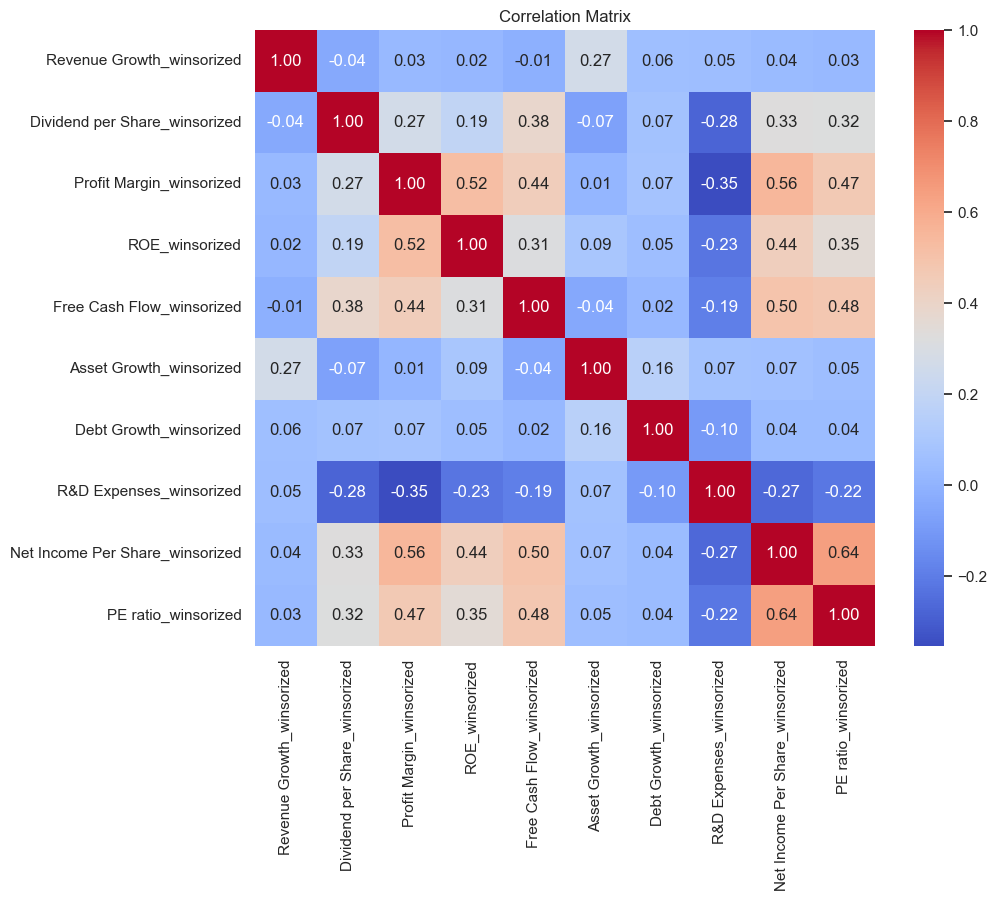

In [47]:
# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(fin_data_log.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

AttributeError: 'PairGrid' object has no attribute 'sample'

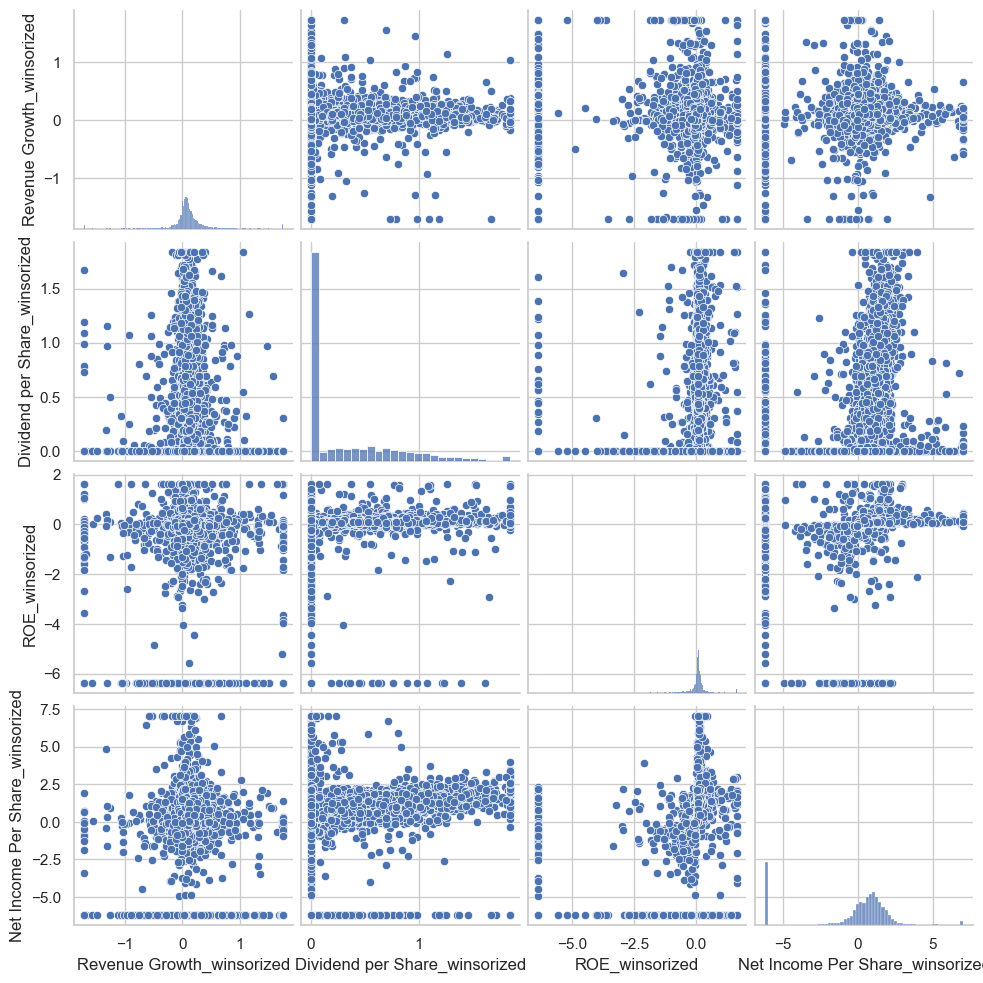

In [49]:
# Pairplot for selected features
selected_features = ['Revenue Growth_winsorized', 'Dividend per Share_winsorized', 'ROE_winsorized', 'Net Income Per Share_winsorized']
sns.pairplot(fin_data_log[selected_features]).sample(1000)
plt.suptitle('Pairplot of Selected Features and Target Variable', y=1.02)
plt.show()

In [57]:
import numpy as np
import pandas as pd

# Find infinite or very large values
print("Contains Inf:", np.isinf(X).values.any())
print("Contains very large values:", (X > 1e308).values.any())  # 1e308 is near the max for float64

Contains Inf: True
Contains very large values: False


In [59]:
X.replace(-np.inf, np.nan, inplace=True)  # Convert -inf to NaN
X.fillna(fin_data_log.min(), inplace=True)  # Replace NaN with the smallest non-inf value

In [61]:
# 3. Data Preprocessing

# 3.1. Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("\nFirst five rows of the scaled features:")
print(X_scaled.head())


First five rows of the scaled features:
   Revenue Growth_winsorized  Dividend per Share_winsorized  \
0                   0.023863                       0.694225   
1                  -0.179443                       0.463904   
2                   0.066416                       0.994735   
3                   0.836819                      -0.726013   
4                  -0.188750                      -0.038962   

   Profit Margin_winsorized  ROE_winsorized  Free Cash Flow_winsorized  \
0                  0.367586        0.324421                   1.749387   
1                  0.359262        0.257345                   1.340261   
2                  0.437484        0.386415                   1.752993   
3                  0.496955        0.459441                   1.668842   
4                  0.209431       -0.589359                   1.081748   

   Asset Growth_winsorized  Debt Growth_winsorized  R&D Expenses_winsorized  \
0                 0.819048                0.601141      

In [63]:
# 3.2. Handling Multicollinearity
X_with_const = sm.add_constant(X_scaled)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print("\nVariance Inflation Factor (VIF) for Each Feature:")
print(vif_data)

high_vif = vif_data[vif_data['VIF'] > 5]
print("\nFeatures with VIF > 5:")
print(high_vif)


Variance Inflation Factor (VIF) for Each Feature:
                           Feature       VIF
0                            const  1.000000
1        Revenue Growth_winsorized  1.080817
2    Dividend per Share_winsorized  1.266844
3         Profit Margin_winsorized  1.846395
4                   ROE_winsorized  1.451904
5        Free Cash Flow_winsorized  1.509812
6          Asset Growth_winsorized  1.134278
7           Debt Growth_winsorized  1.042860
8          R&D Expenses_winsorized  1.214487
9  Net Income Per Share_winsorized  1.734731

Features with VIF > 5:
Empty DataFrame
Columns: [Feature, VIF]
Index: []


In [73]:
X_scaled = X_scaled.drop(["Revenue Growth_winsorized", "ROE_winsorized", 
                          "Asset Growth_winsorized", "Debt Growth_winsorized", 
                          "R&D Expenses_winsorized"], axis=1)

In [75]:
# 4. Splitting the Data
X = X_scaled
y = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 3198 samples
Testing set size: 800 samples


In [77]:
# 5. Modeling

# 5.1. Ordinary Least Squares (OLS) Regression
X_train_ols = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_ols).fit()
print("\nOLS Regression Model Summary:")
print(ols_model.summary())


OLS Regression Model Summary:
                             OLS Regression Results                            
Dep. Variable:     PE ratio_winsorized   R-squared:                       0.457
Model:                             OLS   Adj. R-squared:                  0.457
Method:                  Least Squares   F-statistic:                     672.4
Date:                 Fri, 07 Mar 2025   Prob (F-statistic):               0.00
Time:                         09:56:43   Log-Likelihood:                -4981.9
No. Observations:                 3198   AIC:                             9974.
Df Residuals:                     3193   BIC:                         1.000e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [79]:
# 5.2. Ridge Regression
ridge = Ridge()
parameters_ridge = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_reg = GridSearchCV(ridge, parameters_ridge, scoring='neg_mean_squared_error', cv=5)
ridge_reg.fit(X_train, y_train)

print("\nRidge Regression Best Parameters:")
print(ridge_reg.best_params_)

best_ridge = ridge_reg.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Regression - MSE: {mse_ridge:.4f}, R²: {r2_ridge:.4f}")


Ridge Regression Best Parameters:
{'alpha': 10.0}
Ridge Regression - MSE: 1.2335, R²: 0.4732


In [81]:
# 5.3. Lasso Regression
lasso = Lasso(max_iter=10000)
parameters_lasso = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_reg = GridSearchCV(lasso, parameters_lasso, scoring='neg_mean_squared_error', cv=5)
lasso_reg.fit(X_train, y_train)

print("\nLasso Regression Best Parameters:")
print(lasso_reg.best_params_)

best_lasso = lasso_reg.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Regression - MSE: {mse_lasso:.4f}, R²: {r2_lasso:.4f}")

# Display selected features by Lasso
coef_lasso = pd.Series(best_lasso.coef_, index=X.columns)
selected_features_lasso = coef_lasso[coef_lasso != 0].sort_values(ascending=False)
print("\nSelected Features by Lasso Regression:")
print(selected_features_lasso)


Lasso Regression Best Parameters:
{'alpha': 0.01}
Lasso Regression - MSE: 1.2336, R²: 0.4732

Selected Features by Lasso Regression:
Net Income Per Share_winsorized    0.720309
Free Cash Flow_winsorized          0.262381
Profit Margin_winsorized           0.175597
Dividend per Share_winsorized      0.105527
dtype: float64


In [83]:
# 5.4. Elastic Net Regression
elastic = ElasticNet(max_iter=10000)
parameters_elastic = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}
elastic_reg = GridSearchCV(elastic, parameters_elastic, scoring='neg_mean_squared_error', cv=5)
elastic_reg.fit(X_train, y_train)

print("\nElastic Net Regression Best Parameters:")
print(elastic_reg.best_params_)

best_elastic = elastic_reg.best_estimator_
y_pred_elastic = best_elastic.predict(X_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)
print(f"Elastic Net Regression - MSE: {mse_elastic:.4f}, R²: {r2_elastic:.4f}")

# Display selected features by Elastic Net
coef_elastic = pd.Series(best_elastic.coef_, index=X.columns)
selected_features_elastic = coef_elastic[coef_elastic != 0].sort_values(ascending=False)
print("\nSelected Features by Elastic Net Regression:")
print(selected_features_elastic)


Elastic Net Regression Best Parameters:
{'alpha': 0.1, 'l1_ratio': 0.1}
Elastic Net Regression - MSE: 1.2436, R²: 0.4689

Selected Features by Elastic Net Regression:
Net Income Per Share_winsorized    0.645998
Free Cash Flow_winsorized          0.263065
Profit Margin_winsorized           0.197089
Dividend per Share_winsorized      0.113407
dtype: float64



Model Comparison:
         Model       MSE        R²
0          OLS  1.233321  0.473303
1        Ridge  1.233522  0.473218
2        Lasso  1.233577  0.473194
3  Elastic Net  1.243567  0.468928


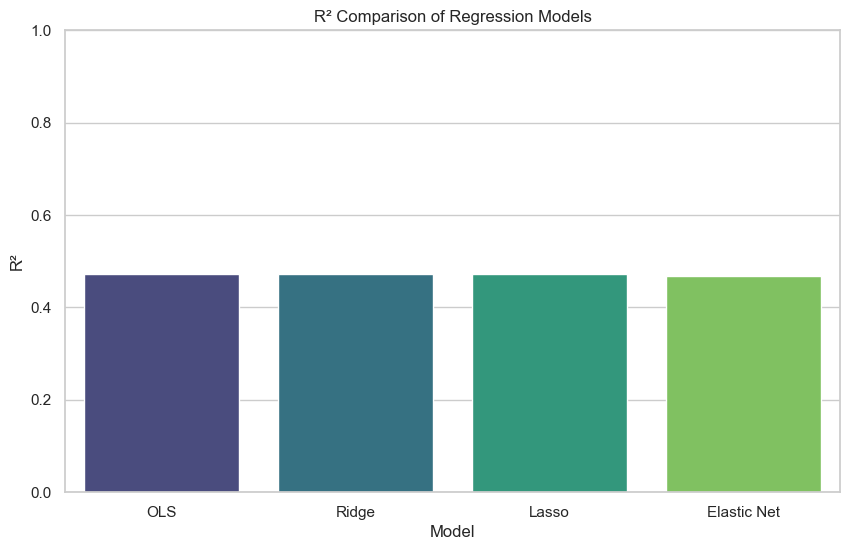

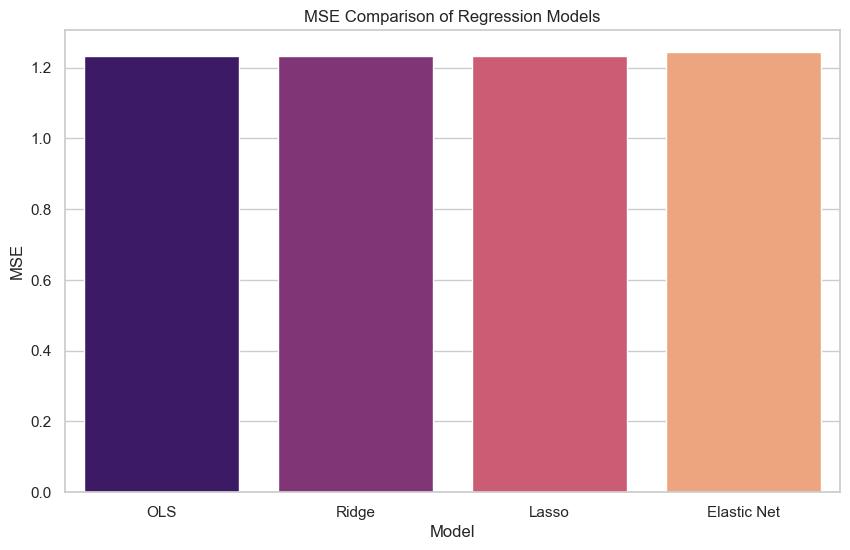

In [85]:
# 6. Model Evaluation and Comparison
model_comparison = pd.DataFrame({
    'Model': ['OLS', 'Ridge', 'Lasso', 'Elastic Net'],
    'MSE': [
        mean_squared_error(y_test, ols_model.predict(sm.add_constant(X_test))),
        mse_ridge,
        mse_lasso,
        mse_elastic
    ],
    'R²': [
        r2_score(y_test, ols_model.predict(sm.add_constant(X_test))),
        r2_ridge,
        r2_lasso,
        r2_elastic
    ]
})

print("\nModel Comparison:")
print(model_comparison)

# Visualize R² Comparison
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='R²', data=model_comparison, palette='viridis')
plt.title('R² Comparison of Regression Models')
plt.ylim(0,1)
plt.show()

# Visualize MSE Comparison
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='MSE', data=model_comparison, palette='magma')
plt.title('MSE Comparison of Regression Models')
plt.show()

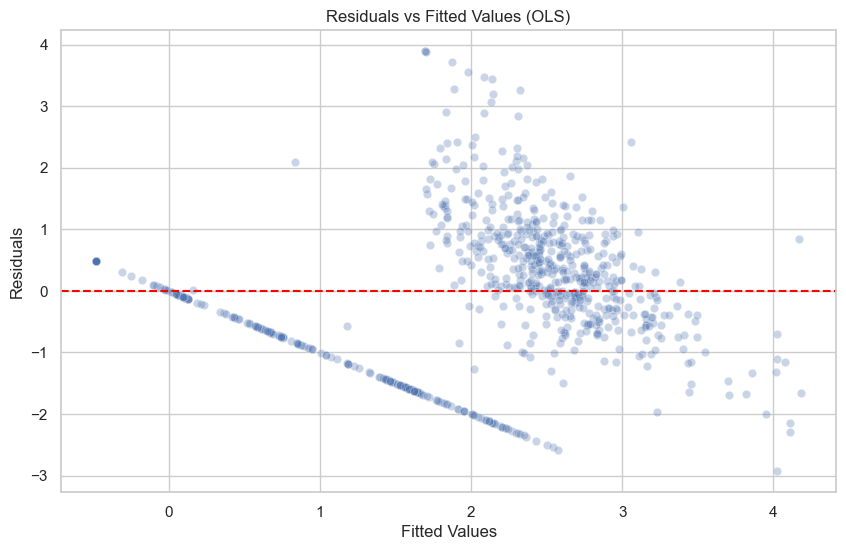

In [99]:
# 7. Regression Diagnostics for the Best Model (Assuming Ridge is Best)

# 7.1. Residuals vs Fitted Values Plot
y_pred_best = ols_model.predict(sm.add_constant(X_test))
residuals_best = y_test - y_pred_best

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred_best, y=residuals_best, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (OLS)')
plt.show()

In [107]:
# 7.2. Durbin-Watson Test
dw_best = durbin_watson(residuals_best)
print(f'\nDurbin-Watson statistic for OLS: {dw_best:.4f}')


Durbin-Watson statistic for OLS: 2.0992


In [105]:
# 7.3. Breusch-Pagan Test
bp_test_best = het_breuschpagan(residuals_best, sm.add_constant(X_test))
bp_lm_stat_best = bp_test_best[0]
bp_p_value_best = bp_test_best[1]
bp_f_stat_best = bp_test_best[2]
bp_f_p_value_best = bp_test_best[3]

print('\nBreusch-Pagan Test Results for OLS:')
print(f'Lagrange multiplier statistic: {bp_lm_stat_best:.4f}')
print(f'p-value: {bp_p_value_best:.4f}')
print(f'f-statistic: {bp_f_stat_best:.4f}')
print(f'f p-value: {bp_f_p_value_best:.4f}')


Breusch-Pagan Test Results for OLS:
Lagrange multiplier statistic: 62.4454
p-value: 0.0000
f-statistic: 16.8273
f p-value: 0.0000


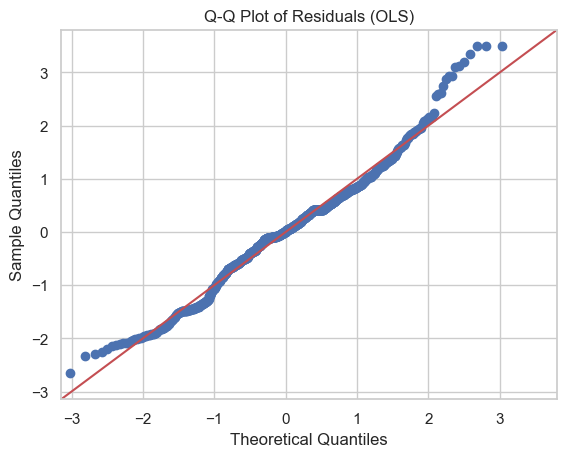


Shapiro-Wilk Test Statistic for OLS: 0.9835
p-value: 0.0000


In [111]:
# 7.4. Q-Q Plot and Shapiro-Wilk Test
sm.qqplot(residuals_best, line='45', fit=True)
plt.title('Q-Q Plot of Residuals (OLS)')
plt.show()

# Shapiro-Wilk Test
shapiro_test_best = shapiro(residuals_best)
print(f'\nShapiro-Wilk Test Statistic for OLS: {shapiro_test_best.statistic:.4f}')
print(f'p-value: {shapiro_test_best.pvalue:.4f}')

In [113]:
# 7.5. Variance Inflation Factor (VIF)
X_test_with_const = sm.add_constant(X_test)
vif_data_best = pd.DataFrame()
vif_data_best['Feature'] = X_test_with_const.columns
vif_data_best['VIF'] = [variance_inflation_factor(X_test_with_const.values, i) for i in range(X_test_with_const.shape[1])]

print('\nVariance Inflation Factor (VIF) for Each Feature (OLS):')
print(vif_data_best)


Variance Inflation Factor (VIF) for Each Feature (OLS):
                           Feature       VIF
0                            const  1.010525
1    Dividend per Share_winsorized  1.203049
2         Profit Margin_winsorized  1.427738
3        Free Cash Flow_winsorized  1.405470
4  Net Income Per Share_winsorized  1.554161
